<a href="https://colab.research.google.com/github/masood76/masood76/blob/main/Assignment3_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Upgrade dependencies

In [ ]:

!pip install pm4py
!pip install --upgrade shap
!pip install --upgrade lime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import the libraries

In [ ]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import pm4py
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
import lime
import lime.lime_tabular

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, Dropout
from tensorflow.keras.layers import Embedding, LSTM, BatchNormalization, MaxPooling1D
from tensorflow.keras import optimizers, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import pprint
import datetime
import shap
import matplotlib
from google.colab import drive


Found GPU at: /device:GPU:0


# Check the versions

In [ ]:
print('pd.__version__: ',pd.__version__)
print('np.__version__: ',np.__version__)
print('keras.__version__: ',keras.__version__)
print('pm4py.__version__: ',pm4py.__version__)
print('tf.__version__: ',tf.__version__)
print('shap.__version__: ',shap.__version__)
print('matplotlib.__version__: ',matplotlib.__version__)

pd.__version__:  1.5.3
np.__version__:  1.22.4
keras.__version__:  2.12.0
pm4py.__version__:  2.7.3
tf.__version__:  2.12.0
shap.__version__:  0.41.0
matplotlib.__version__:  3.7.1


# Parsing the log file and start filtering

In [ ]:
# Mount your Google Drive
drive.mount('/content/drive')

# Access Read the log file in the Google Drive and get the data
file_path = '/content/drive/MyDrive/Colab Notebooks/BPI_Challenge_2012.xes'
log = pm4py.read_xes(file_path)


# Get all loan applications in the dataset
activities = [v for v, _ in pm4py.get_event_attribute_values(log, "concept:name").items()]
        
# Filter the dataset for all the completed events
filtered_log_completed = pm4py.filter_event_attribute_values(log, "lifecycle:transition", ["COMPLETE"], level="event", retain=True)
filtered_log_completed = pm4py.filter_event_attribute_values(log, "lifecycle:transition", ["COMPLETE"], level="event", retain=True)

# Set a prefix length of 7 and filter the log for cases with at least 7 events
prefix_len = 7
filtered_log_completed_pref = pm4py.filter_case_size(filtered_log_completed, prefix_len, np.max([len(case) for case in filtered_log_completed]))
filtered_log_completed_pref = filtered_log_completed_pref.to_numpy()

# Set up variables for building the vocabulary
X, y, vocabulary, tokenize_vocabulary, reverse_tokenize_vocabulary = [], [], activities, {}, {}     
vocabulary_size = len(activities)
        
# Set up variables for training the model
X, y = [], []       
epochs = 10
batch_size = 64

# Tokenize each activity in the vocabulary and set up dictionaries for tokenization
index = 1
for event in vocabulary:
    print('event: ', event)
    tokenize_vocabulary[event] = index
    reverse_tokenize_vocabulary[index] = event
    index = index + 1

Mounted at /content/drive


ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

Boolean Series key will be reindexed to match DataFrame index.


event:  W_Completeren aanvraag
event:  W_Nabellen offertes
event:  W_Nabellen incomplete dossiers
event:  W_Valideren aanvraag
event:  W_Afhandelen leads
event:  A_SUBMITTED
event:  A_PARTLYSUBMITTED
event:  A_DECLINED
event:  A_PREACCEPTED
event:  O_SENT
event:  O_CREATED
event:  O_SELECTED
event:  A_ACCEPTED
event:  A_FINALIZED
event:  O_CANCELLED
event:  O_SENT_BACK
event:  A_CANCELLED
event:  A_REGISTERED
event:  A_ACTIVATED
event:  A_APPROVED
event:  O_ACCEPTED
event:  O_DECLINED
event:  W_Beoordelen fraude
event:  W_Wijzigen contractgegevens


# Print some data to double check our variables

In [ ]:
# This line of code prints out the reverse_tokenize_vocabulary dictionary,
# which maps integer indices to activity names. This is useful for decoding
# the predictions made by the model, which are integer indices.
print(reverse_tokenize_vocabulary)

{1: 'W_Completeren aanvraag', 2: 'W_Nabellen offertes', 3: 'W_Nabellen incomplete dossiers', 4: 'W_Valideren aanvraag', 5: 'W_Afhandelen leads', 6: 'A_SUBMITTED', 7: 'A_PARTLYSUBMITTED', 8: 'A_DECLINED', 9: 'A_PREACCEPTED', 10: 'O_SENT', 11: 'O_CREATED', 12: 'O_SELECTED', 13: 'A_ACCEPTED', 14: 'A_FINALIZED', 15: 'O_CANCELLED', 16: 'O_SENT_BACK', 17: 'A_CANCELLED', 18: 'A_REGISTERED', 19: 'A_ACTIVATED', 20: 'A_APPROVED', 21: 'O_ACCEPTED', 22: 'O_DECLINED', 23: 'W_Beoordelen fraude', 24: 'W_Wijzigen contractgegevens'}


In [ ]:
print(filtered_log_completed_pref[0])
t = str(filtered_log_completed_pref[1][3])
print(t)
t = t[:23]
print(t)
datetime_obj = datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f')

year = datetime_obj.year
month = datetime_obj.month
day = datetime_obj.day
hour = datetime_obj.hour
minute = datetime_obj.minute
second = datetime_obj.second
microsecond = datetime_obj.microsecond

print(year, month, day, hour, minute, second, microsecond)


['112' 'COMPLETE' 'A_SUBMITTED'
 Timestamp('2011-09-30 22:38:44.546000+0000', tz='UTC')
 Timestamp('2011-09-30 22:38:44.546000+0000', tz='UTC') '173688' '20000']
2011-09-30 22:38:44.880000+00:00
2011-09-30 22:38:44.880
2011 9 30 22 38 44 880000


# Defining a function to get the time stamps data

In [ ]:
org_resource, time_stamp, Reg_date, concept_name, Amount_req = [],[],[],[],[]
time_stamp_day,time_stamp_hour,time_stamp_minute,time_stamp_second,time_stamp_microsecond=[],[],[],[],[]
Reg_date_day,Reg_date_hour,Reg_date_minute,Reg_date_second,Reg_date_microsecond=[],[],[],[],[]
def Memory(trace):
    statu = False
    timestamp = str(trace[3])
    timestamp = timestamp[:26]
    
    Regdate = str(trace[4])
    Regdate = Regdate[:26]
    
    try:
        timestamp_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
        Regdate_obj = datetime.datetime.strptime(Regdate, '%Y-%m-%d %H:%M:%S.%f')
        time_stamp_day.append(timestamp_obj.day)
        time_stamp_hour.append(timestamp_obj.hour)
        time_stamp_minute.append(timestamp_obj.minute)
        time_stamp_second.append(timestamp_obj.second)
        time_stamp_microsecond.append(timestamp_obj.microsecond)
        Reg_date_day.append(Regdate_obj.day)
        Reg_date_hour.append(Regdate_obj.hour)
        Reg_date_minute.append(Regdate_obj.minute)
        Reg_date_second.append(Regdate_obj.second)
        Reg_date_microsecond.append(Regdate_obj.microsecond)
        org_resource.append(float(trace[0]))
        time_stamp.append(timestamp)
        Reg_date.append(Regdate)
        concept_name.append(float(trace[5]))
        Amount_req.append(float(trace[6]))
    except ValueError:
        statu = True
        return statu
        pass


# Create a Data frame from our data

In [ ]:
def Dataframe_creator(X, y, time_stamp,time_stamp_day, Reg_date,Reg_date_day, org_resource, concept_name, Amount_req):
    
    data = {
        'org_resource': np.ravel(org_resource),
        'time_stamp': np.ravel(time_stamp),
        'time_stamp_day': np.ravel(time_stamp_day),
        'Reg_date': np.ravel(Reg_date),
        'Reg_date_day': np.ravel(Reg_date_day),
        'concept_name': np.ravel(concept_name),
        'Amount_req': np.ravel(Amount_req),
        'X': np.ravel(X),
        'y': np.ravel(y)
    }
    df = pd.DataFrame(data)
    return df

# Create the arrays and dataframe from our trace and events

In [ ]:
X, y = [], []
org_resource, time_stamp, Reg_date, concept_name, Amount_req = [],[],[],[],[]
time_stamp_day,time_stamp_hour,time_stamp_minute,time_stamp_second,time_stamp_microsecond=[],[],[],[],[]
Reg_date_day,Reg_date_hour,Reg_date_minute,Reg_date_second,Reg_date_microsecond=[],[],[],[],[]

for trace in filtered_log_completed_pref:
    statu = Memory(trace)
    if statu == True:
        continue
    list_events_in_current_trace = []
    y.append(tokenize_vocabulary[trace[2]])
    list_events_in_current_trace.append(tokenize_vocabulary[trace[2]])
    X.append(list_events_in_current_trace)

#         X = np.array(X)
#         y = np.array(y)
df = Dataframe_creator(X, y, time_stamp,time_stamp_day, Reg_date,Reg_date_day, org_resource, concept_name, Amount_req)

df = df.dropna()
df.head(10)

,org_resource,time_stamp,time_stamp_day,Reg_date,Reg_date_day,concept_name,Amount_req,X,y
0,112.0,2011-09-30 22:38:44.546000,30,2011-09-30 22:38:44.546000,30,173688.0,20000.0,6,6
1,112.0,2011-09-30 22:38:44.880000,30,2011-09-30 22:38:44.546000,30,173688.0,20000.0,7,7
2,112.0,2011-09-30 22:39:37.906000,30,2011-09-30 22:38:44.546000,30,173688.0,20000.0,9,9
3,10862.0,2011-10-01 09:42:43.308000,1,2011-09-30 22:38:44.546000,30,173688.0,20000.0,13,13
4,10862.0,2011-10-01 09:45:09.243000,1,2011-09-30 22:38:44.546000,30,173688.0,20000.0,12,12
5,10862.0,2011-10-01 09:45:09.243000,1,2011-09-30 22:38:44.546000,30,173688.0,20000.0,14,14
6,10862.0,2011-10-01 09:45:11.197000,1,2011-09-30 22:38:44.546000,30,173688.0,20000.0,11,11
7,10862.0,2011-10-01 09:45:11.380000,1,2011-09-30 22:38:44.546000,30,173688.0,20000.0,10,10
10,10913.0,2011-10-08 14:32:00.886000,8,2011-09-30 22:38:44.546000,30,173688.0,20000.0,2,2
11,11049.0,2011-10-10 09:33:03.668000,10,2011-09-30 22:38:44.546000,30,173688.0,20000.0,16,16


In [ ]:
df.shape

(49337, 9)

In [ ]:
Df = df.drop(['time_stamp','Reg_date'],axis=1)
Df['org_resource'] = Df['org_resource'].astype('float32')
Df['time_stamp_day'] = Df['time_stamp_day'].astype('float32')
Df['Reg_date_day'] = Df['Reg_date_day'].astype('float32')
Df['concept_name'] = Df['concept_name'].astype('float32')
Df['Amount_req'] = Df['Amount_req'].astype('float32')
y_data = Df['y'].values
X_data = Df.drop(['y'], axis=1).values
Df['X'] = Df['X'].astype('float32')
Df['y'] = Df['y'].astype('float32')
Df2 = Df.drop(['y'],axis=1)


# Show a demo of all our data

In [ ]:
Df.head()

,org_resource,time_stamp_day,Reg_date_day,concept_name,Amount_req,X,y
0,112.0,30.0,30.0,173688.0,20000.0,6.0,6.0
1,112.0,30.0,30.0,173688.0,20000.0,7.0,7.0
2,112.0,30.0,30.0,173688.0,20000.0,9.0,9.0
3,10862.0,1.0,30.0,173688.0,20000.0,13.0,13.0
4,10862.0,1.0,30.0,173688.0,20000.0,12.0,12.0


# Show a demo of our input data

In [ ]:
Df2.head()

,org_resource,time_stamp_day,Reg_date_day,concept_name,Amount_req,X
0,112.0,30.0,30.0,173688.0,20000.0,6.0
1,112.0,30.0,30.0,173688.0,20000.0,7.0
2,112.0,30.0,30.0,173688.0,20000.0,9.0
3,10862.0,1.0,30.0,173688.0,20000.0,13.0
4,10862.0,1.0,30.0,173688.0,20000.0,12.0


# Print the data type and the features' name

In [ ]:
print(Df.dtypes)    

org_resource      float32
time_stamp_day    float32
Reg_date_day      float32
concept_name      float32
Amount_req        float32
X                 float32
y                 float32
dtype: object


In [ ]:
print(Df2.columns.tolist())

['org_resource', 'time_stamp_day', 'Reg_date_day', 'concept_name', 'Amount_req', 'X']


# Split training and testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

# Define an RNN model

In [ ]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model_one_layer = Sequential()
model_one_layer.add(tf.keras.layers.Reshape((6, 1), input_dim=X_train.shape[1]))
model_one_layer.add(LSTM(32))
model_one_layer.add(Activation("sigmoid"))
model_one_layer.add(Dense(vocabulary_size+1, activation='softmax'))
        
model_one_layer.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics="accuracy")

stringlist = []
model_one_layer.summary(print_fn=lambda x: stringlist.append(x))


# Fit the data to the model

In [ ]:
history_one_layer = model_one_layer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test), verbose=1)

accuracy = model_one_layer.evaluate(X_test,y_test, verbose=1)
print('Test set\n  Loss: {:0.3f}\n  accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]*100))

Epoch 1/10
517/517 [==============================] - 11s 9ms/step - loss: 2.5824 - accuracy: 0.2306 - val_loss: 2.3867 - val_accuracy: 0.2299
Epoch 2/10
517/517 [==============================] - 3s 6ms/step - loss: 2.2445 - accuracy: 0.3085 - val_loss: 2.1330 - val_accuracy: 0.3766
Epoch 3/10
517/517 [==============================] - 3s 5ms/step - loss: 2.0658 - accuracy: 0.3508 - val_loss: 1.9918 - val_accuracy: 0.3033
Epoch 4/10
517/517 [==============================] - 3s 5ms/step - loss: 1.9440 - accuracy: 0.4106 - val_loss: 1.8755 - val_accuracy: 0.4879
Epoch 5/10
517/517 [==============================] - 3s 6ms/step - loss: 1.8263 - accuracy: 0.4709 - val_loss: 1.7634 - val_accuracy: 0.4808
Epoch 6/10
517/517 [==============================] - 4s 7ms/step - loss: 1.7184 - accuracy: 0.4910 - val_loss: 1.6633 - val_accuracy: 0.4879
Epoch 7/10
517/517 [==============================] - 3s 5ms/step - loss: 1.6330 - accuracy: 0.5111 - val_loss: 1.5863 - val_accuracy: 0.5613
Epoch

# Save the trained model

In [ ]:
model_one_layer.save('model_one_layer_hd')

# Permutate our data and then get some samples for the explanation section

In [ ]:
num_samples = 100
shuffled_indices = np.random.permutation(X_test.shape[0])
sampled_indices = shuffled_indices[:num_samples]
Sampled_X_test = X_test[sampled_indices, :]

shuffled_indices = np.random.permutation(X_train.shape[0])
sampled_indices = shuffled_indices[:num_samples]
Sampled_X_train = X_train[sampled_indices, :]


# Define the SHAP explainer

In [ ]:
# generate a figure to generally explain the model
explainer = shap.KernelExplainer(model_one_layer, Sampled_X_train)
shap_values = explainer.shap_values(Sampled_X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

# General interpretation by SHAP values - summary plot

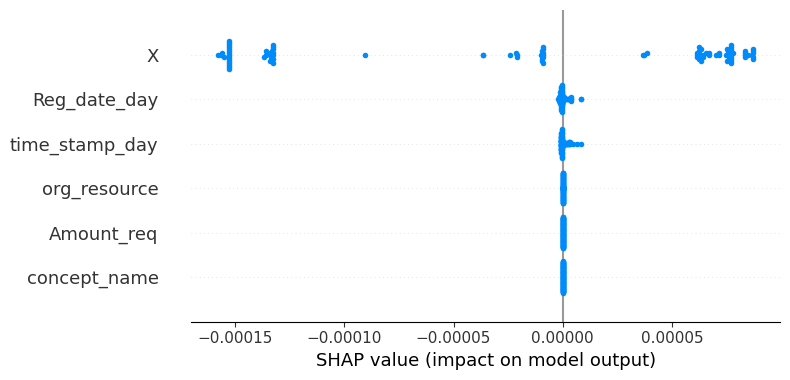

In [ ]:
shap.summary_plot(shap_values[0],feature_names=Df2.columns.tolist(),color_bar=True,color_bar_label='Feature value')

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


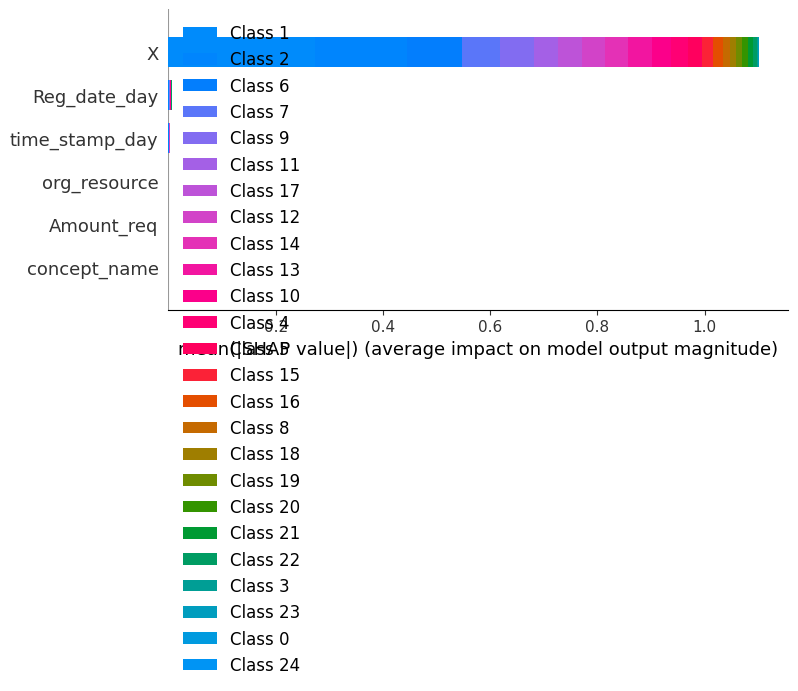

In [ ]:
# generate a figure to generally explain the model
shap.summary_plot(shap_values,feature_names=Df2.columns.tolist())

# Local interpretation by SHAP values - force plot

In [ ]:
# generate a figure to explain an instance
shap.initjs()
base_value = explainer.expected_value
sample_index = 0
shap.force_plot(base_value[sample_index], shap_values[sample_index], feature_names=Df2.columns.tolist())

# LIME interpretation

In [ ]:
#LIME tabular interpretation method
explainer_LIME = lime.lime_tabular.LimeTabularExplainer(Sampled_X_train, mode='classification',feature_names=Df2.columns.tolist())

# asking for explanation for LIME model
i = 1
prob = model_one_layer.predict(X_test)
exp = explainer_LIME.explain_instance(data_row=X_test[i], predict_fn=model_one_layer.predict, num_features=10)


157/157 [==============================] - 0s 2ms/step


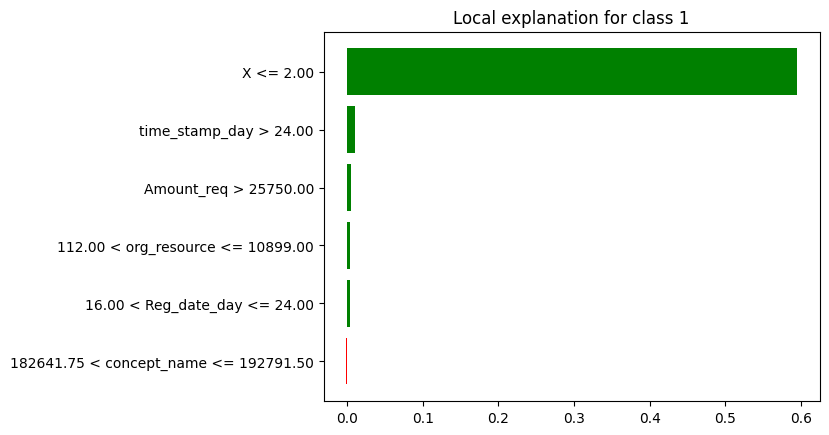

In [ ]:
# generate a pyplot figure for the explanation
fig = exp.as_pyplot_figure()

# display the figure
plt.show()

For comparison, to different interpretation methods are presented consisting of SHAP and LIME methods. SHAP method is eployed to explain our model in two different ways; general interpretation and local interpretation.

LIME interpretation method can be used to explain the model prediction for a single instance.